# Road to Vision Zero - Chicago Crash Data Analysis

![image](https://github.com/nickthetj/DSC-Phase3-Project/assets/126971652/9e88f1d6-2353-4ad1-95ec-1f7329edad13)


## Overview


The City of Chicago would like to gain more insight into traffic accidents given information about the car, the people in the car, and the road conditions. They plan on pursuing the goals of Vision Zero, an organization with a strategy to eliminate all traffic fatalities and severe injuries, while increasing safe, healthy, equitable mobility for all. Our project involves the examination of crash data sourced from the City of Chicago's Data Portal to further this mission. By analyzing this data, we hope to create a predictive model that can help evaluate trends across crashes. Through this comprehensive analysis, we will be able to make recommendations for Chicago to make their streets safer.

## Business Problem

Vision Zero believes that the loss of even a single life is unacceptable. This is especially true because traffic accidents are not actually accidents at all; they are crashes, because they are preventable. In order to move Chicago closer to this vision, our data analysis led to the following recommendations:

Pedestrian/Cyclist Safety
Traffic Rule Adherence

Continue below to see how we arrived at these recommendations and what Chicago can do to prioritize these measures.

## Data Understanding

![image](https://github.com/nickthetj/DSC-Phase3-Project/assets/126971652/5bb378f0-e0b8-467f-bb04-e8fbb7767fa5)



The datasets used in this analysis come from the City of Chicago's Data Portal. We analyzed over 740,00 crashes from the City of Chicago's Data Portal ranging from 2016 to 2022. 

Specifically, we used three seperate CSV files:
- [Crash Data](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if) displays information about each traffic collision that occurred on city streets within the City of Chicago and within the jurisdiction of the Chicago Police Department (CPD).
- [Vehicles Data](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3) contains information about vehicles (or units as they are identified in crash reports) involved in a traffic crash. 
- [People Data](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if) comprises information about the people involved in a crash and whether or not they were injured. 


## Data Preparation

A core component of Vision Zero is that the loss of even a single life is unacceptable. To gain insight into how to prevent deaths, we classified the data into two categories: crashes that resulted in Fatalities, and crashes that did not result in Fatalities.

We trained a Logistic Regression Model as well as a Decision Tree Model. As Fatal crashes only consisted of about 1% of our dataset, we used a Pipeline to supplement the class with SMOTE to allow our model to better learn this category. We one hot encoded all 14 categorical columns which allowed the model to learn to classify each crash as Fatal or Not Fatal based on 238 features such as the weather, the time of day, the type of crash, and more.

We tuned our model with GridSearch to constantly improve our recall score. We chose to focus on recall score to minimize the likelihood of our model predicting a crash as Not Fatal, when it was in fact Fatal.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, recall_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

### Reading Data

To run our models, our team has to save the CSV files locally with the paths in the cell below. These CSV files do not exist in our repo as they were too large to push up. They can be downloaded via the links under the **Data Understanding** section above. Save those downloaded files with the paths below, then this notebook can be run locally. 

In [18]:
# reading CSVs
vehicle_df = pd.read_csv('../data/localdata/Traffic_Crashes_Vehicles.csv')
people_df = pd.read_csv('../data/localdata/Traffic_Crashes_People.csv')
crash_df = pd.read_csv('../data/localdata/Traffic_Crashes_Crashes.csv')

/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (20,24,25,26,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Data Cleaning

We chose the most relevant columns for our predictors and reformatted the column names in this section.

In [19]:
# Crashes DataFrame Cleaning

crash_df.drop(columns=['WORK_ZONE_I', 'WORK_ZONE_TYPE', 'DOORING_I', 'WORKERS_PRESENT_I',
                                          'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'RD_NO', 'REPORT_TYPE', 'CRASH_DATE_EST_I'], axis=1, inplace=True)
crash_df.dropna(subset = ['INJURIES_TOTAL', 'LATITUDE', 'MOST_SEVERE_INJURY', 
                          'STREET_DIRECTION', 'BEAT_OF_OCCURRENCE'], axis=0, inplace=True)
crash_df.columns = crash_df.columns.str.title()
crash_df.columns = crash_df.columns.str.replace('_', ' ')

In [20]:
# Vehicles DataFrame Cleaning

vehicle_df = vehicle_df[['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO', 'UNIT_TYPE',
                       'VEHICLE_YEAR', 'VEHICLE_USE', 'VEHICLE_TYPE', 'VEHICLE_DEFECT', 'MANEUVER', 'OCCUPANT_CNT',
                         'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I',
                       'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I', 'AREA_10_I', 'AREA_11_I',
                       'AREA_12_I', 'AREA_99_I', 'FIRST_CONTACT_POINT']]
vehicle_df.dropna(subset = ['VEHICLE_USE', 'FIRST_CONTACT_POINT', 'UNIT_TYPE'], axis=0, inplace=True)
vehicle_df['VEHICLE_YEAR'].fillna(value = 'Unknown', inplace=True)

vehicle_df.columns = vehicle_df.columns.str.title()
vehicle_df.columns = vehicle_df.columns.str.replace('_', ' ')

In [21]:
# People DataFrame Cleaning

people_df.drop(columns=['RD_NO', 'CELL_PHONE_USE', 'PEDPEDAL_ACTION', 
                        'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'SEAT_NO', 
                        'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'BAC_RESULT', 'BAC_RESULT VALUE', 
                        'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'CITY', 'STATE', 'ZIPCODE']
               , axis=1, inplace=True)

people_df.dropna(subset = ['AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'VEHICLE_ID', 
                           'SAFETY_EQUIPMENT', 'SEX'], axis=0, inplace=True)

people_df.columns = people_df.columns.str.title()
people_df.columns = people_df.columns.str.replace('_', ' ')

### Feature Engineering Crash Score

For our first iteration of a target variable, we feature engineered a **Crash Score** which was a linear combination of different types of injuries from most severe to least severe. The more severe injuries were weighted with a higher constant than the less severe injuries. This linear combination also took into account car damage, but this was weighted far lower. The end result was a number that rated every incident with a score depicting how severe a crash was. 

In [22]:
# Injury Score

crash_df[['Injuries Total', 'Injuries Fatal', 'Injuries Incapacitating', 
            'Injuries Non Incapacitating', 'Injuries Reported Not Evident']][crash_df['Injuries Total']!=0][:50]

crash_df['total injured'] = crash_df['Injuries Fatal'] + crash_df['Injuries Incapacitating'] + crash_df['Injuries Non Incapacitating'] + crash_df['Injuries Reported Not Evident']

# Checking if added up columns in 'total injured' make up 'Injuries Total'
(crash_df['total injured'] == crash_df['Injuries Total']).value_counts()

# Injury Score column is a linear combination of the factors that make up Injuries Total simply multiplied by a constant depending on their severity
crash_df['Injury Score'] = crash_df['Injuries Fatal']*7 + crash_df['Injuries Incapacitating']*3 + crash_df['Injuries Non Incapacitating']*2 + crash_df['Injuries Reported Not Evident']

# Accounting Material Damage of Car and Surrounding Areas )
# Crash Score 

crash_df['Damage'].value_counts()
mapping = {'OVER $1,500': 3, '$501 - $1,500': 2, "$500 OR LESS": 1}
crash_df['Damage_ODE'] = crash_df['Damage'].map(mapping)
crash_df['Injury Score'] = crash_df['Injury Score'] + crash_df['Damage_ODE']*3
crash_df['Crash Score'] = crash_df['Injury Score']

We ended up dropping this feature engineered target in favor of a simpler binary target, depicting if an acccident involved fatal injuries and if it did not.

### Creating Binary Target (Fatal or not Fatal)

This function determined if an accident involved fatal or not fatal accidents, and binned them accordingly.

In [23]:
def fill_fatal_class_rows(row):
    if row["Injuries Fatal"] > 0 :
        return 'Fatal'
    else:
        return 'Not Fatal'

crash_df['Fatality Classification'] = crash_df.apply(fill_fatal_class_rows, axis=1)

Distribution between non fatal and fatal crashes.

In [24]:
crash_df['Fatality Classification'].value_counts(normalize=True)

Not Fatal    0.998912
Fatal        0.001088
Name: Fatality Classification, dtype: float64

### Merging Vehicle and Crash DataFrames

For our predictors, we used a set of columns belonging to both the Vehicles and Crashes dataset. We merged these columns together into one dataframe and OneHotEncoded all of these predictors since they were all categorical data.

In [25]:
vehicles_crashes_df = vehicle_df.merge(crash_df, on = 'Crash Record Id', how = 'inner')
vehicles_crashes_df.drop_duplicates(subset='Crash Record Id', inplace=True)

In [26]:
categorical = ['Weather Condition', 'Roadway Surface Cond', 'Road Defect', 'Alignment',
                       'Traffic Control Device', 'Device Condition', 'Crash Hour', 'Trafficway Type', 'Maneuver', 'Vehicle Defect',
               'Lighting Condition', 'First Crash Type', 'Prim Contributory Cause', 'Sec Contributory Cause'] #potentiall vehicle defects

ohe = OneHotEncoder(drop='first')
ohe.fit(vehicles_crashes_df[categorical])

categorical_encoded = pd.DataFrame(ohe.transform(vehicles_crashes_df[categorical]).todense(),
                               columns=ohe.get_feature_names())

## Modeling

Throughout our modelling process, we evaluated the performance of a model based on the recall score. False Negatives in this case means that our model predicted a crash to be Not Fatal when in actuality it was Fatal. As lives are of the upmost importance, we want to minimize that chance of a False Negative as much as possible. 

### Creating Train Test Split for Fatal vs. Not Fatal

All of our modelling will be conducted on the training set of data. After choosing the model with the highest recall score based on our training data, then we evaluate it on unseen data (testing). 

In [27]:
X = categorical_encoded
y = vehicles_crashes_df['Fatality Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Dummy Model

#### Instantiating the Model

In [ ]:
#Instantiate dummy model that will always predict majority class
dummy_model = DummyClassifier(strategy="most_frequent", random_state = 42)
dummy_model.fit(X_train, y_train)

y_true = y_train
y_pred = dummy_model.predict(X_train)
recall_score(y_true, y_pred, pos_label='Fatal')

We created a recall scorer for all of our models to use for evaluation.

In [ ]:
recall_scorer = make_scorer(recall_score, pos_label='Fatal')

The cell below is our recall score for the Dummy Model. Our goal is to improve from this towards 1 as much as possible.

In [ ]:
cv_score_dummy = cross_val_score(estimator = dummy_model, X=X_train, y=y_train, scoring = recall_scorer, n_jobs=-1).mean()
cv_score_dummy

### Logistic Regression Model

Our Logistic Regression Model ended up becoming the final model we used for our presentation as it generated the highest recall score.

#### Instantiating the Model

Printed below is our baseline accuracy of the logistic regression model

In [28]:
logreg = LogisticRegression(random_state=42, max_iter = 2000, class_weight = 'balanced', penalty = 'none')
logreg.fit(X_train, y_train)
y_true = y_train
y_pred = logreg.predict(X_train)
recall_score(y_true, y_pred, pos_label = 'Fatal')

0.8611570247933884

#### Data Processing through a Pipeline

We decided to use smote to produce more data points for events that resulted in fatal injuries because we want our model to be able to parse out what makes a incident fatal. With our initial distribution of fatal to non fatal accidents (Fatal: 0.001088, Not Fatal: 0.998912), we felt our model did not have enough data points belonging to the fatal category to make these connections. Thus we tweaked this distribution by generating synthetic data points in the fatal category using smote (Fatal: 0.3, Not Fatal: 0.7).

Our pipeline, logpipe, simplified this process by chaining the two estimators together.

In [29]:
logpipe = Pipeline([('smote', SMOTE(random_state=42, sampling_strategy = 0.3)),
                    ('model', logreg)])
logpipe.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    penalty='none', random_state=42))])

Cross validated recall scores

In [ ]:
cv_score_logpipe = cross_val_score(estimator=logpipe, X=X_train, y=y_train, scoring = recall_scorer, n_jobs = -1).mean()
cv_score_logpipe

In [ ]:
recall_score(y_true, y_pred, pos_label = 'Fatal')

In [ ]:
plot_confusion_matrix(logreg, X_train, y_train, labels = ['Not Fatal', 'Fatal'], cmap = plt.cm.Blues);

#### Parameter Tuning with GridSearchCV

Returns the best parameter combination with associated recall score

In [ ]:
logreg = LogisticRegression(random_state=42, max_iter = 2000, n_jobs= -1, class_weight = 'balanced')

logpipe = Pipeline([('smote', SMOTE(random_state=42, n_jobs=-1)),
                    ('model', logreg)])

param_grid = {
    "smote__sampling_strategy": [0.3, 0.4, 0.5],
    "model__C": np.logspace(-4, 4, 4),
    "model__penalty": ['l1', 'none']
}

search = GridSearchCV(logpipe, param_grid, scoring= recall_scorer, n_jobs=-1)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

#### Relevant coefficients for Logistic Regression Model

We generated the following dataframe to gain some inferential understanding as to what factors increased the chances (log odds) of an accident being categorized as fatal by our model. 

In [30]:
coefficients_table = logpipe.named_steps['model'].coef_
coefficients_table = coefficients_table.transpose()
coefficients_table = [-x[0] for x in coefficients_table]
coefficients = pd.Series(list(coefficients_table), name = 'coefficients')
features = pd.Series(list(categorical_encoded), name = 'features')
coefs_df = pd.DataFrame([coefficients, features]).transpose()
coefs_df.sort_values(by='coefficients', inplace=True, ascending=False)
coefs_df.head(15)

,coefficients,features
189,16.2876,x12_PHYSICAL CONDITION OF DRIVER
174,14.6623,x12_EXCEEDING AUTHORIZED SPEED LIMIT
175,13.4487,x12_EXCEEDING SAFE SPEED FOR CONDITIONS
165,13.2781,x12_DISREGARDING TRAFFIC SIGNALS
162,13.2449,x12_DISREGARDING OTHER TRAFFIC SIGNS
187,12.9252,"x12_OPERATING VEHICLE IN ERRATIC, RECKLESS, CA..."
185,12.8587,x12_NOT APPLICABLE
190,12.8035,x12_RELATED TO BUS STOP
170,12.8021,x12_DRIVING ON WRONG SIDE/WRONG WAY
168,12.6752,x12_DISTRACTION - FROM OUTSIDE VEHICLE


We exported this table to use in our tableau dashboard for visualization

In [31]:
coefs_df.to_csv('../data/localdata/coefs.csv', index=True)

This model was the best with a recall score of .70. As you can see in the confusion matrix, the model is minimizing the amount of False Negatives. In other words, the model is minimizing the chance that it predicts a crash as Not Fatal when it was in fact Fatal. 

![confusionmatrix](https://github.com/nickthetj/DSC-Phase3-Project/assets/37059423/2894b1db-d4c1-480c-9e06-3953708f6424)

Our model also revealed which coefficients were most relevant in terms of predicting fatalities. Here you can see that dark blue is the Primary Cause of Crash, light blue is the Traffic Control Device, orange is the Crash Type, and yellow is the Maneuver the car took resulting in the crash. 

![Sheet 2 (1)](https://github.com/nickthetj/DSC-Phase3-Project/assets/126971652/bfa16c00-66b8-498e-bea6-6f0a592fddd9)

To get a further analysis on those coefficients, we calculated the Fatality percentage for each. 

![Sheet 3 (3)](https://github.com/nickthetj/DSC-Phase3-Project/assets/126971652/8c68050a-9466-4418-bf19-91270fcbb117) 

To no surprise, the top cause of a fatal crash is the Physical Condition of the Driver. Following that is Exceeding Authorized Speed Limit and Driving on the wrong side of the road. While Physical Condition of the Driver is a pressing issue, we came up with an easy to implement recommendation that may be able to curb the speed limit issue and Driving on the Wrong side of the road. As for the Crash Type, we focused our recommendation on minimizing Pedestrian fatalities, but believe it can also minimize the other features as well. 

#### Coefficients as a percentage of fatalities

The following is code for how we created the chart above titled **Feature Fatality Percentage**

In [32]:
#reset y index so can merge with X on the index
y.reset_index(drop = True, inplace = True)

#Merge dfs to be able to perform calculations with all data together
categorical_and_fatal_df = X.merge(y, left_index = True, right_index = True, how = 'right')

#Confirm merge was successful. Should have same # of rows as before with one more column than X
categorical_and_fatal_df.shape

(745092, 239)

In [33]:
#Function takes in a dataframe and relevant columns.
#Function loops through each column, calculating the percentage of Fatalities for each column's involvment in crashes
#Function outputs a dataframe with column names and their Fatality Percentage in descending order
def calc_percentage(df, columns):
    
    percent_dict = {}
    
    for col in columns:    
        #Calculate percentage
        col_perc = len(df.loc[(df[col]==1) & (df['Fatality Classification']=='Fatal')]) / len(df.loc[df[col]==1])
        #Add percentage to dictionary
        percent_dict[col] = col_perc
    #Convert dictionary to DataFrame
    percent_df = pd.DataFrame.from_dict(percent_dict, orient='index', columns=['Fatality Percentage'])
    percent_df.sort_values(by = 'Fatality Percentage', ascending = False, inplace = True)
    
    return percent_df

In [ ]:
relevant_columns = coefs_df['features'].unique()[45:].tolist() #select columns to analyze the fatal percentage of
coef_fatal_percent_df = calc_percentage(categorical_and_fatal_df, relevant_columns)

#Group by index for easier group analysis
#grouped_feature_fatal_percent_df = feature_fatal_percent_df.sort_index()

#Output df to csv for graph making in Tableau
coef_fatal_percent_df.to_csv('../data/localdata/coef_fatal_percent.csv', index=True)

### Decision Tree Model

We did not choose this model as our final model. It produced an overall lower recall score compared to logistic regression, but our modelling process is here to view anyway.

#### Instantiating the Model

In [ ]:
#Instantiating Decision Tree with new parameters to increase recall score
clf_1 = DecisionTreeClassifier(criterion='gini', random_state=42, class_weight = 'balanced', max_depth = 24,
                                   min_samples_split = 2500)

clf_1.fit(X_train, y_train)

y_preds = clf_1.predict(X_train)

print('Recall: ', recall_score(y_train, y_preds, pos_label = 'Fatal'))

#### Data Processing through a Pipeline

In [ ]:
#Create Pipeline with new model
clf_1pipe = Pipeline([('smote', SMOTE(random_state=42, sampling_strategy = 0.3)),
                    ('model', clf_1)])

In [ ]:
#Cross Validating Decision Tree with pipeline
cv_score_clf_1pipe = cross_val_score(estimator=clf_1pipe, X=X_train, y=y_train, scoring = recall_scorer).mean()
cv_score_clf_1pipe

#### Relevant features for Decision Tree Model

In [ ]:
feature_importance = clf_1.feature_importances_

feature_importances = pd.Series(list(feature_importance), name = 'feature_importance')
features = pd.Series(list(categorical_encoded), name = 'features')

features_df = pd.DataFrame([feature_importances, features]).transpose()

features_df.sort_values(by='feature_importance', inplace=True, ascending=False)

features_df.head(15)

## Evaluation on Testing Data

Overall, our Logistic Regression Model performed the best with a final recall score of 0.71

In [ ]:
y_preds_test = clf_1pipe.predict(X_test)
print('Final Recall Score for Decision Tree Model: ', recall_score(y_test, y_preds_test, pos_label = 'Fatal'))

In [35]:
y_pred_test = logpipe.predict(X_test)

print("Final Recall Score for Logistic Model: ", recall_score(y_test, y_pred_test, pos_label = 'Fatal'))

Final Recall Score for Logistic Model:  0.7009803921568627


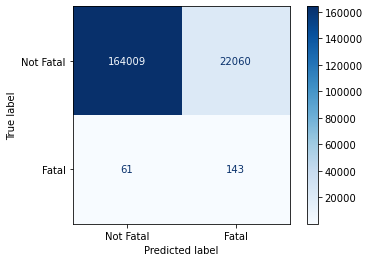

In [36]:
plot_confusion_matrix(logpipe, X_test, y_test, labels = ['Not Fatal', 'Fatal'], cmap = plt.cm.Blues);

## Recommendations

We recommend Chicago look to the Strong Towns organization and what they have accomplished in restructuring the development of cities to be more suitable and safer for citizens.

Our first recommendation is to redesign your crosswalks. Raising the Crosswalks increases its visibility and makes it clear to both driver and pedestrian that this area of the street is designed for the pedestrian's safety first by forcing the driver to slow down as they approach.

![image](https://github.com/nickthetj/DSC-Phase3-Project/assets/126971652/7f05dd49-1770-48a6-8b30-e2e964a71a86)

Our Second recommendation is to narrow the size of the street by introducing bike lanes. Many city streets have low speed limits but are wide by design so that drivers feel comfortable speeding. By tightening the space around them and introducing bake lanes with barriers to separate them from the the car lanes, drivers will be more attentive to their surroundings and more inclined to slow down.
![image](https://github.com/nickthetj/DSC-Phase3-Project/assets/126971652/2ae7b332-5d82-42c8-8aff-b9999b83ae10)

In conclusion, our model with .71 recall score shows two main ideas:

One, that Pedestrians and Cyclists are most at risk for fatalities.

And two, that fatal crashes are likely to be caused by drivers not following the rules of the road.

We believe Chicago can move closer to zero fatalities by implementing raised crosswalks and narrower streets via protected bike lanes.

## Next Steps

There are a few steps we would like to take to further limit fatalities in car crashes:<br>
1. Crash Location Investigation
2. BAC Investigation
   
For the crash location investigation, the datasets we worked with provided some information available on the location of every crash, but it was broken down by street. It might be easier and more efficient to break the city down into areas or districts to highlight particular problem areas of the city that could be reformed.

For the BAC investigation, the top preliminary cause and fatal percentage of fatal crashes was the Physical Condition of the Driver. With more time we could investigate how much of this was due to drunk drivers or drivers under the influence of drugs.

## Thank You

Thank you for taking the time to review our recommendations.
We hope this information helps and we look forward to working with you more on the next steps.

Sincerely, 

Bobby Daly, Michael Romanski, Nicholas Tjandra 

## Repository Structure

```
├── data
      |── dataplaceholder.txt
├── notebooks
├── images
├── README.md
├── .gitignore
├── .DS_Store
├── The Road to Vision Zero Presentation.pdf
└── Final EDA Notebook.ipynb
```